- KEYWORDS: energy balance, batch


In [1]:
from IPython.core.display import Image, display
display(Image(url='https://usercontent2.hubstatic.com/209665_f520.jpg', width=300))

-   There are no flows in the batch reactor

-   The mole balances are

$\frac{dn_j}{dt} = r_j V $

-   We assume the volume is constant and pressure is constant
    -   This is practically valid for liquid phase reactions and constant mole reactions

-   The energy balance becomes

$\sum N_j C_{p,j} \frac{dT}{dt} = - \sum H_j \alpha_j r V + \dot{W}_s + \dot{Q} $

-   Recall that $\Delta H_{rx} = \sum \alpha_j H_j$

-   This leads to

$\sum N_j C_{p,j} \frac{dT}{dt} = - \Delta H_{rx} r V + \dot{W}_s + \dot{Q} $

## Constant volume, adiabatic batch reactor

-   Let us consider a constant volume, adiabatic batch reactor
    -   Adiabatic means no heat enters or leaves the reactor, $\dot{Q} = 0$
    -   We will neglect any shaft work $\dot{W}_S=0$
-   We consider the reaction $A + B \rightarrow C$
    -   Since this is a liquid reaction, we assume constant pressure
-   The reaction mixture starts at 27 °C with initial concentrations of $A$ and $B$ at 2 M, and no C
-   The heat of reaction is -10 kcal/mol
-   The partial molar heat capacities are $\overline{C}_{pA} = \overline{C}_{pB} = 20$ cal/(mol K) and  $\overline{C}_{pC} = 40$ cal/mol/K.
-   The rate constant is $k = 0.01725$ L/mol/min at 27 °C  and the activation energy is 1500 cal/mol/K
-   The reactor volume is 1200 L
-   We will neglect the temperature dependence of the rate constant and reaction enthalpy
-   We will assume the reaction is liquid phase and it is incompressible
-   We want to plot the temperature and concentration vs. time
-   Since the reactor is adiabatic $\dot{Q}=0$
-   We are left with this for the energy balance for the constant volume, adiabatic batch reactor:

<div class="alert alert-warning">
$$\frac{dT}{dt} =  \frac{-\Delta H_R\; r\; V_r}{ \sum N_i C_{p,i} } $$
</div>

-   We can relate the number of moles of $A$, $B$ and $C$ via the reaction extent and stoichiometry.

We start with the input data. Note there will be more of this than for isothermal reactor problems because we need all the thermal properties.

In [1]:
import numpy as np
from scipy.integrate import odeint

V = 1200.0 # L
T0 = 273.15 + 27
CA0 = CB0 = 2.0
CC0 = 0.0

# heat capacities
cpa = cpb = 20.0  # cal/mol/K
cpc = 40.0        # cal/mol/K

# rate constants
k0 = 0.01725      # L / mol / min at 27 °C
E = 1500.0        # cal/mol
R = 1.987         # cal/mol/K
dH = -10000.0     # cal/mol

The coupled mole and energy balance will also be more involved as we need to consider the temperature dependence of the rates.

In [1]:
def adiabatic_batch(Y, t):
    na, T = Y

    # extent based on moles
    xi = (na - CA0 * V) / -1.0
    nb = CB0 * V - xi
    nc = CC0 * V + xi

    # concentrations
    Ca = na / V
    Cb = nb / V

    # temperature dependent rate constant
    k = k0 * np.exp(-E / R * (1.0 / T - 1.0 / T0))
    r = k * Ca * Cb

    dnadt = -r * V

    # energy balance
    dTdt = -(dH * r * V)/(na * cpa + nb * cpb + nc * cpc)
    return [dnadt, dTdt]

Finally, solve the problem.

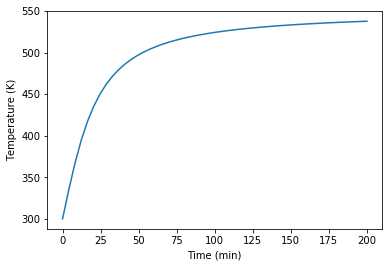

In [1]:
# initial conditions
Y0 = [V * CA0, T0]

tspan = np.linspace(0, 200)
sol = odeint(adiabatic_batch, Y0, tspan)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tspan, sol[:,1])
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')

-   You can see that because of the exothermic reaction, the temperature increases signifcantly, from about 300K to almost 550 K.
    -   This increases the rate constant and the reaction rate

-   The temperature rise begins to slow because the reaction rate slows down due to consumption of reactants

-   Considering  a solvent like water would boil at about 373K there may be a safety concern here as the pressure would then start to significantly increase in the reactor

## Batch with heat exchanger

-   Let us reconsider the last example, but now add a heat exchanger.
    -   This could be as simple as immersing the batch reactor in a coolant that is well-stirred and at constant temperature
    -   Or it could be a heat exchanger immersed in the reactor
-   Now $\dot{Q} \ne 0$
-   We need a model for the heat exchange
-   A common model is $\dot{Q} = Ua(T_{coolant} - T)$
    -   $Ua$ is an overall heat transfer coefficient with units energy / volume / time
    -   If $T > T_{coolant}$ there is loss of heat from the reactor
    -   We write the heat transfer this way so we can *add* $\dot{Q}$ in the energy balance
-   Let $UA = 5000$ cal/L/min, and the temperature of the coolant be 77 °C
-   The energy balance becomes

<div class="alert alert-warning">
$$\frac{dT}{dt} =  \frac{-\Delta H_R r V_r + Ua(T_{coolant} - T)}{ \sum n_i C_{p,i} } $$
</div>

In [1]:
import numpy as np
from scipy.integrate import odeint

V = 1200.0 # L
T0 = 273.15 + 27
CA0 = CB0 = 2.0
CC0 = 0.0

cpa = cpb = 20.0  # cal/mol/K
cpc = 40.0        # cal/mol/K

k0 = 0.01725    # L / mol / min at 27 degC
E = 1500.0     # cal/mol
R = 1.987       # cal/mol/K
dH = -10000.0  # cal/mol

Ua = 5000.0  # overall heat transfer coefficient
Tcoolant = 77 + 273.15  # coolant temperature

Here is the adapted mole and energy balance.

In [1]:
def batch(Y, t):
    na, T = Y
    xi = (na - CA0*V) / -1.0
    nb = CB0 * V - xi
    nc = CC0 * V + xi

    Ca = na / V
    Cb = nb / V
    k = k0 * np.exp(-E / R * (1.0 / T - 1.0 / T0))
    r = k * Ca * Cb
    ra = -r

    Qdot = Ua * (Tcoolant - T)

    dnadt = ra * V
    dTdt = (-dH * r * V + Qdot)/(na * cpa + nb * cpb + nc * cpc)
    return [dnadt, dTdt]

And the integrated solution.

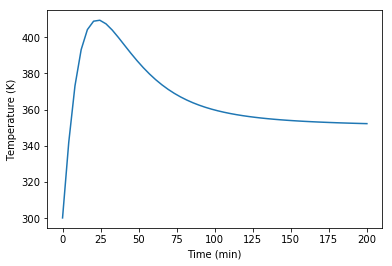

In [1]:
Y0 = [V * CA0, T0]

tspan = np.linspace(0, 200)
sol = odeint(batch, Y0, tspan)
import matplotlib.pyplot as plt
plt.plot(tspan, sol[:,1])
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')

-   Note that the temperature initially rises
    -   Partly because of the exothermic reaction occuring
    -   Partly because the initial temperature is lower than $T_{coolant}$ so there is heat transferred into the reactor

-   But it does not rise as quickly or as high as the adiabatic case

-   After a while the temperature begins to drop
    -   Because we are removing heat whenever $T > T_{coolant}$

-   Over time the temperature will approach $T_{coolant}$

-   We might still have to consider safety concerns here
    -   There is still a 100 K increase in temperature
    -   Using a heat exchanger with larger $Ua$ would help reduce that
    -   Using a lower temperature in the coolant would help that
    -   Using lower initial concentration would help that
    -   Diluting with a high heat capacity solvent would help that

# Summary

-   The energy balance adds one additional equation, and many additional data requirements
    -   heat capacities, activation energies, reaction enthalpies, heat transfer coefficients